# Homework 2 

- Implement Naive Bayes model (remember about smoothing). 
- Find a reasonably interesting but not to complicated dataset for which you will be able to use this model to perform binary classification. Do the latter.
- Produce the confussion matrix, calculate accuracy, precission, recall
- Check how your model does against its version from sklearn and logistic regression from sklearn. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import math
import random

import warnings
warnings.filterwarnings('ignore')


# to make this notebook's output stable across runs
np.random.seed(100)

In [3]:
%matplotlib inline
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import precision_score, recall_score

In [53]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [6]:
#with this function we split data into training and testing parts
def splitDataSet(dataset, ratio):
    length = range(len(dataset))
    rangeT = random.sample(length, int(ratio * len(dataset)))
    rangeT.sort()
    
    trainrange = list(set(length) ^ set(testrange))
    test = dataset.ix[testrange]
    train = dataset.ix[trainrange]

    return train, test

In [54]:
#then we're separating it by the same class
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        array = dataset[i]
        if(array[-1] not in separated):
            separated[array[-1]] = []
        separated[array[-1]].append(array)
    return separated

In [8]:
def summarize(dataset):
    summaries = [(np.mean(n), np.std(n)) for n in zip(*dataset)]
    del summaries[-1]
    return summaries

In [9]:
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classvalue, instances in separated.items():
        summaries[classvalue] = summarize(instances)
    return summaries

In [56]:
#bayes implementation
def calculateProbability(x, mean, stdev):
    exp = math.exp(-(math.pow(x-mean,2) / (2*math.pow(stdev,2))))
    return(1/(math.sqrt(2*math.pi)*stdev)) * exp

In [58]:
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities

In [59]:
def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel

In [60]:
def getPredictions(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(summaries, testSet[i])
        predictions.append(result)
    return predictions

In [61]:
def getAccuracy(testSet, predictions):
    correct = 0;
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100

In [62]:
def confusionMatrix(true, pred):
    result = np.zeros((2, 2))

    for i in range(len(true)):
        trueval = true[i][1]
        if(trueval == pred[i] and pred[i] == 0):
            result[0][0] += 1
        elif(trueval != pred[i] and pred[i] == 1):
            result[1][0] += 1
        elif(trueval != pred[i] and pred[i] == 0):
            result[0][1] += 1
        elif(trueval == pred[i] and pred[i] == 1):
            result[1][1] += 1

    return result

In [63]:
data = pd.read_csv("diabetes_scale.csv",sep=";",encoding='latin-1')
data.head()

,diabetes,1,2,3,4,5,6,7,8
0,-1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


In [64]:
#Dropping columns
data = data.drop(["2","3","4","5","6","7","8"], axis=1)
data['label'] = data.diabetes.map({-1:0,1:1})
data.diabetes = data.label
data = data.drop(["diabetes"], axis=1)
data = data.rename(columns={"1":"factor"})
data.head()

,factor,label
0,-0.294118,0
1,-0.882353,1
2,-0.058824,0
3,-0.882353,1
4,-1.000000,0


In [65]:
#First we evaluate the data using our implementation of the Bayes Model
splitRatio = 0.2
trainingSet, testSet = splitDataSet(data, splitRatio)
print("Splitting {0} rows into {1} training and {2} testing ranges".format(len(data), len(trainingSet), len(testSet)))

#Conversion into lists
trainingSetlist = trainingSet.values.tolist()
testSetlist = testSet.values.tolist()

Splitting 768 rows into 615 training and 153 testing ranges


In [66]:
#preparing model on numerical data
summaries = summarizeByClass(trainingSetlist)

In [67]:
#testing model against the testSet
predictions = getPredictions(summaries, testSetlist)
accuracy = getAccuracy(testSetlist, predictions)
print("Accuracy: {0}%".format(accuracy))

Accuracy: 66.66666666666666%


[[22. 23.]
 [28. 80.]]


Text(0.5,12,'Predicted label')

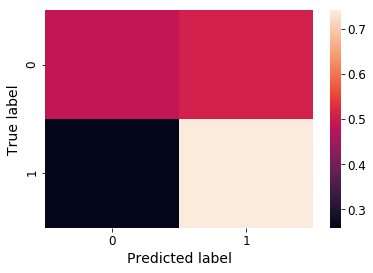

In [68]:
#Producing a confusion matrix
confmat = confusionMatrix(testSetlist, predictions)
print(confmat)
confmat_normalized = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
sns.heatmap(confmat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [69]:
#Calculating precision and recall scores
precision = confmat.item(1, 1)/(confmat.item(1, 1) + confmat.item(0, 1))
recall = confmat.item(1, 1)/(confmat.item(1, 1) + confmat.item(1, 0))
print("Precision: {0}\nRecall: {1}".format(precision, recall))

Precision: 0.7766990291262136
Recall: 0.7407407407407407


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_train,X_test,y_train,y_test = train_test_split(data["factor"],data["label"], test_size = 0.2, random_state = 10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614,)
(154,)
(614,)
(154,)


In [73]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

AttributeError: 'float' object has no attribute 'lower'

In [106]:
model = LogisticRegression()
model.fit(X_train_df,y_train)
prediction = model.predict(X_test_df)
acc = accuracy_score(y_test,prediction)
print("Accuracy: {0}%".format(acc*100))

NameError: name 'X_train_df' is not defined

In [107]:
conf_mat = confusion_matrix(y_test, prediction)
print("Sklearn Confusion Matrix:\n{0}\nMy Confusion Matrix:\n{1}".format(conf_mat, confmat))

NameError: name 'prediction' is not defined

In [108]:
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

NameError: name 'conf_mat' is not defined

In [109]:
print(classification_report(y_test, prediction, target_names = ["Factor", "Diabetes"]))

NameError: name 'prediction' is not defined